# the zig zag

From the book:

We first pre-calculate the table with 
$$
C(n,p) = \sum_{k=1}^{n} s(k)s(k+p)
$$

Then we approximate the exponent by, which is to be maximised:
$$
- \sum_{k=1}^{K} \sum_{n_k - 1}^{n_k - p_k} (s(n_k+p_k)-s(n))^2
$$

which is approximated by
$$
- 2 \sum_{n=1}^{40000} s(n)^2 + 2 \sum_{k=1}^{K}(C(n_k,p_k) - C(n_{k-1},p_k))
$$

Our objective is to maximise the summation
$$
\sum_{k=1}^{K}(C(n_k,p_k) - C(n_{k-1},p_k))
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
n = 2048
period_prev = 120

real_start_time = 533
real_period = 44100./300.
print("real period: {}".format(real_period))

real period: 147.0


# defining the signal

### with spliced sine waves

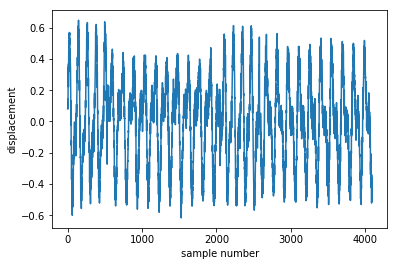

In [4]:
sine_prev = (0.4*np.sin(2*np.pi/period_prev*np.arange(0,real_start_time) + np.random.randn())
            + 0.2*np.sin(4*np.pi/period_prev*np.arange(0,real_start_time) + np.random.randn())
            )
sine_next = (0.3*np.sin(2*np.pi/real_period*np.arange(real_start_time,n) + np.random.randn()) 
            + 0.2*np.sin(4*np.pi/real_period*np.arange(real_start_time,n) + np.random.randn())
            )

sine_prev1 = (0.4*np.sin(2*np.pi/period_prev*np.arange(0,real_start_time) + np.random.randn())
            + 0.2*np.sin(4*np.pi/period_prev*np.arange(0,real_start_time) + np.random.randn())
            )  
# sine_prev[:real_start_time] = [0]*real_start_time
sine_next1 = (0.3*np.sin(2*np.pi/real_period*np.arange(real_start_time,n) + np.random.randn()) 
            + 0.2*np.sin(4*np.pi/real_period*np.arange(real_start_time,n) + np.random.randn())
            )


sine = np.concatenate((sine_prev, sine_next, sine_prev1, sine_next1))
s = np.add(0.05*np.random.randn(n*2), sine)

plt.plot(s)
plt.xlabel("sample number")
plt.ylabel("displacement")
plt.show()

### importing the signal
suitable signal is necessary, however

In [ ]:
period_prev = 100  # not exactly

import os
import soundfile as sf
# read file
fileDir = os.path.dirname(os.path.realpath('__file__'))
file_name = os.path.join(fileDir, '../sounds/marsh mono.wav')
file_name = os.path.abspath(os.path.realpath(file_name))
ref, sample_rate = sf.read(file_name)

t_start = 0.65
t_end = 29.0
signal = ref[int(t_start * 44100): int(t_end * 44100), 0]
chunksize = 2048

signal_length = chunksize
# run this once only
entry_start_number = 1748
s = np.array(signal[entry_start_number:entry_start_number+chunksize])

n = chunksize

plt.plot(s)
ax = plt.gca()
ax.set_xlim([0, chunksize])
ax.set_ylim([-1, 1])
plt.xlabel("sample number")
plt.ylabel("displacement")
plt.show()

### using multivar Gaussian

In [ ]:
def frequency_modulation(spectrum, freq_profile_):
    #modulation = [np.arctan(x/100.) * np.exp(-x/200.) for x in range(1,n)]
    modulation = freq_profile_
    spectrum = np.multiply(np.abs(spectrum), modulation)
    return spectrum


def complete_magnitude(magnitude):
    # the input is the absolute value, excludes zero at 0 - total of N/2 - 1
    phase = [2 * np.pi * np.random.random() for angle in range(len(magnitude))]
    reals = np.multiply(magnitude, np.sin(np.array(phase)))
    imags = np.multiply(magnitude, np.cos(np.array(phase)))

    fcef = complete_realimags(reals, imags)
    return fcef


def complete_realimags(reals, imags):
    # the input excludes zero at 0 - total of N/2 - 1 entries
    reals = np.concatenate([reals, reals[::-1]])
    reals = np.insert(reals, int(len(reals) / 2), 0)
    reals = np.insert(reals, 0, 0)

    imags = np.concatenate([imags, -1 * np.array(imags[::-1])])
    imags = np.insert(imags, int(len(imags) / 2), 0)
    imags = np.insert(imags, 0, 0)

    fcef = np.vectorize(complex)(reals, imags)
    return fcef

In [ ]:
notes_start = [0., 0.5+(real_start_time/44100.), 1]  # start times (the last entry is end time)
notes_freq = [44100./period_prev, 300]  # frequencies of notes
number_of_notes = len(notes_freq)

# signal = np.zeros(int(1+time*sampling_rate))
# signal = [0]*(2*44100)
# window_time = np.sqrt(np.hamming(44100))
window_time = [np.arctan(400.*x) * np.exp(-3.0*x) for x in np.arange(0.,1.,1/44100.)]
# plt.plot(sound)
# plt.show()

b = 0.01
a = 1

N = 44100

freq_profile = [(x / 10.) * np.exp(-x / 400.) for x in range(1, int(N/2))]

In [ ]:
# overlap
signal = [0]*(2*44100)

for i in range(number_of_notes):
    
    time = notes_start[i]
    freq = notes_freq[i]
    
    spectrum = [(b + 4*a*((np.sin(np.pi*freqz/freq))**2)) ** -0.5 
                for freqz in range(1, int(N/2))]
    spectrum = np.multiply(spectrum, np.random.randn(22049))
    spectrum = frequency_modulation(spectrum, freq_profile)  # frequency modulation
    fcef = complete_magnitude(spectrum)    
#     plt.plot(spectrum[:1000])
#     plt.show()
    
    sound = np.fft.ifft(fcef).real
    sound = np.multiply(sound, window_time)  # time modulation
    signal[int(time*44100): int(time*44100)+44100] += sound 

In [ ]:
# no overlap
signal = [0]*(2*44100)

for i in range(number_of_notes):
        
    time_start = notes_start[i]
    time_end = notes_start[i+1]
    freq = notes_freq[i]
    
    spectrum = [(b + 4*a*((np.sin(np.pi*freqz/freq))**2)) ** -0.5 
                for freqz in range(1, int(N/2))]
    spectrum = np.multiply(spectrum, np.random.randn(22049))
    spectrum = frequency_modulation(spectrum, freq_profile)  # frequency modulation
    fcef = complete_magnitude(spectrum)
#     plt.plot(spectrum[:1000])
#     plt.show()
    
    sound = np.fft.ifft(fcef).real
    sound = np.multiply(sound, window_time)  # time modulation        
    signal[int(time_start*44100.): 
           int(time_end*44100.)] += sound[:int(44100*(time_end))-
                                          int(44100*(time_start))]

In [ ]:
plt.plot(signal)
plt.xlabel("sample number")
plt.ylabel("displacement")
plt.show()

s[:2048] = signal[int(0.5*44100):int(0.5*44100)+2048]

# signal pre-processing

In [5]:
# defining constants and range
period_prev = 79

a = 1
b = 0.01

cee_time_plot_start = 0 # try 0
cee_time_plot_end = 3500 # try 2000
cee_time_plot_range = cee_time_plot_end - cee_time_plot_start
cee_period_plot_start = 105 # try 0
cee_period_plot_end = 160 # try 100
cee_period_plot_range = cee_period_plot_end - cee_period_plot_start

X = np.arange(cee_time_plot_start, cee_time_plot_end, 1)
Y = np.arange(cee_period_plot_start, cee_period_plot_end, 1)

In [6]:
cee = np.zeros((cee_time_plot_range, cee_period_plot_range))

# for t in range(signal_length):
for p in range(cee_period_plot_start, cee_period_plot_end):
    p_ = p - cee_period_plot_start  # array index is not actual period length
    # cumsum so that you do not need to calculate everything again and again
    # what is the difference between two square brackets and a comma in a square bracket?
    cee[:,p_] = np.cumsum(np.multiply(s[:cee_time_plot_end],
                                    s[p:cee_time_plot_end+p]))

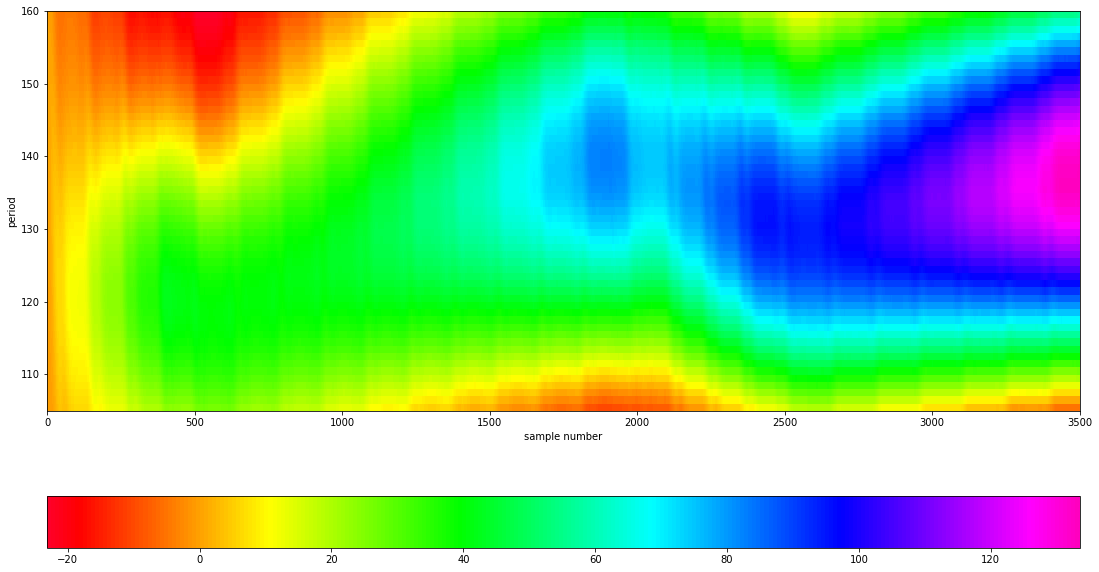

In [7]:
# orienting the graph to plot correctly

cee_ = np.transpose(cee)
# position = np.array(np.unravel_index(Z.argmin(), Z.shape))

# time_minimum = time_plot_start + position[1]
# freq_minimum = period_plot_start + position[0]

cee_ = np.flip(cee_, 0)

import matplotlib.cm as cm
import matplotlib.colors as colors

img = plt.imshow(cee_, cmap=cm.gist_rainbow, aspect='auto', 
                 extent=[cee_time_plot_start, 
                         cee_time_plot_end, 
                         cee_period_plot_start, 
                         cee_period_plot_end], 
                )

plt.colorbar(orientation="horizontal")
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# plt.scatter([real_start_time],[real_period], color="k")
# plt.scatter([time_plot_start + position[1]], [period_plot_start + position[0]], color="g")
plt.xlabel("sample number")
plt.ylabel("period")
plt.show()

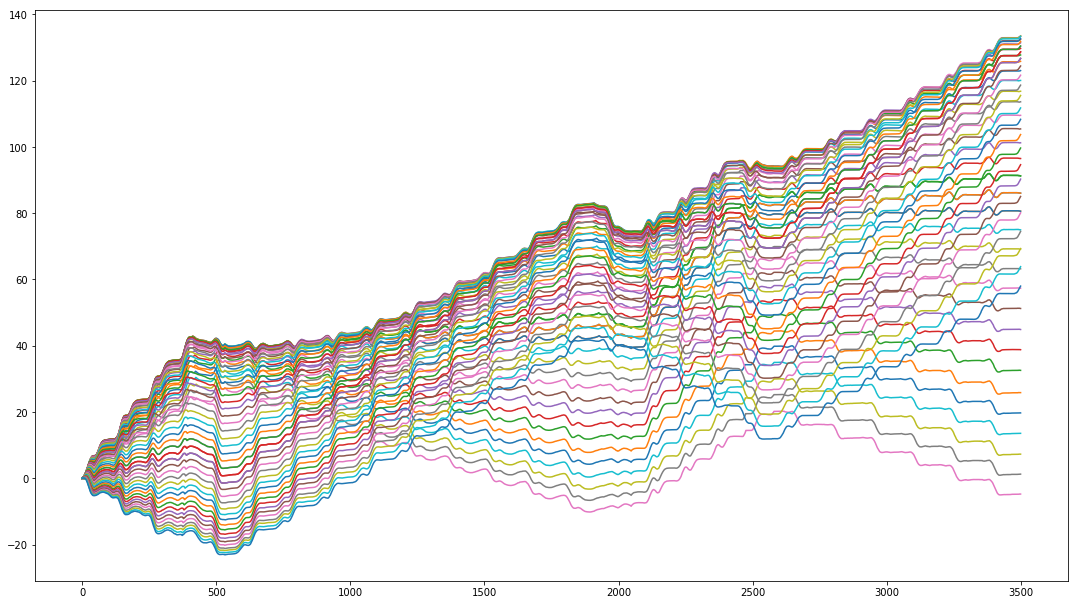

In [12]:
plt.plot(cee[:,15])
plt.plot(cee[:,14])
plt.plot(cee[:,16])

plt.plot(cee[:,37])
plt.plot(cee[:,36])
plt.plot(cee[:,38])

plt.plot(cee[:,:])


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()